# Topics in English Quran

In [1]:
import glob
from collections import defaultdict
import pdb
import time
import re
import sys

from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.util import ngrams
from gensim import corpora, models
# from gensim.utils import lemmatize  # not working with PY3.7 due to Pattern package
from wordcloud import WordCloud
import spacy
import pyLDAvis
import pyLDAvis.gensim

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
pd.set_option('max_colwidth', 400)
pd.set_option('display.max_rows', 500)

# import nltk
# nltk.download()

## Pre-processing

In [2]:
sura_medina = [2, 3, 4, 5, 8, 9, 22, 24, 33, 47, 48, 49, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 98, 110]
sura_mecca_first = [96, 74, 111, 106, 108, 104, 107, 102, 105, 92,
90, 94, 93, 97, 86, 91, 80, 68, 87, 95,
103, 85, 73, 101, 99, 82, 81, 53, 84, 100,
79, 77, 78, 88, 89, 75, 83, 69, 51, 52,
56, 70, 55, 112, 109, 113, 114, 1]
sura_mecca_second = [54, 37, 71, 76, 44, 50, 20, 26, 15, 19,
38, 36, 43, 72, 67, 23, 21, 25, 17, 27, 18]
sura_mecca_third = [32, 41, 45, 16, 30, 11, 14, 12, 40, 28,
39, 29, 31, 42, 10, 34, 35, 7, 46, 6, 13]
sura_ind = [sura_mecca_first, sura_mecca_second, sura_mecca_third, sura_medina]
ALL_SURAH_INDICES = range(1, 115)

BASMALA = 'in the name of allah, the gracious, the merciful.'

In [92]:
def read_in_quran(suras_indices=ALL_SURAH_INDICES, data_folder='../data/quran-verse-by-verse-text/'):
    documents = [] 
    i_surah = []
    i_verse = []
    for chapter in suras_indices:
        files = sorted(glob.glob(data_folder + str(chapter).zfill(3) + '*'))
        # Remove non ascii and change to lower case; not necessary with RegexpTokenizer(r'\w+')
        surah = []
        for ind_verse, f in enumerate(files):
            with open(f, 'rb') as hf:
                text = hf.read()
                verse = text.decode('utf-8').encode('ascii', errors='ignore').lower().decode('utf-8')
                surah.append(verse)
                i_surah.append(chapter)
                i_verse.append(ind_verse + 1)
        documents.append(surah)  
    return documents, i_surah, i_verse

def remove_basmala(documents, i_verse=None):
    if isinstance(documents[0], list):  # if the input is by surah (list of list)
        for doc in documents:
            if BASMALA in doc:
                doc.remove(BASMALA)
    else:
        if i_verse is None:
            print('Must provide verse indices for document by verse')
            return None
        for i, _ in enumerate(i_verse):
            if documents[i] == BASMALA:
                del i_verse[i]
                del i_surah[i]
                del documents[i]

def tokenize_docs(docs):
    # removing whitespaces and punctuations
    tokenizer = RegexpTokenizer(r'\w+')
    for document in docs:
        yield(tokenizer.tokenize(document))

def remove_stopwords(docs, additional_stops=None):
    stop = stopwords.words('english')
    if additional_stops is not None:
        stop = stop + additional_stops 
    return [[word for word in doc if word not in stop] for doc in docs]

def lemmatization(docs, is_stemming=False):
    stem_map = defaultdict(lambda : defaultdict(int))
    
    parsed_docs = []
    if is_stemming:  # do stemming
        stemmer = PorterStemmer()
        for doc in docs:
            parsed_doc = []
            for word in doc:
                stemmed = stemmer.stem(word)
                parsed_doc.append(stemmed)
                stem_map[stemmed][word] += 1
            parsed_docs.append(parsed_doc)
    else:  # do lemmatization with stacy
        # Initialize spacy 'en' model, keeping only tagger component needed for lemmatization
        nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])  # en_core_web_sm.load(disable=['parser', 'ner'])
        # Extract the lemma for each token and join
        for doc in docs:
            nlp_parsed = nlp(' '.join(doc))
            parsed_doc = []
            for word in nlp_parsed: 
                lemma = word.lemma_
                parsed_doc.append(lemma)
                stem_map[lemma][word.text] += 1
            parsed_docs.append(parsed_doc)
    return parsed_docs, stem_map

def parse_docs(docs, is_stop=True, additional_stops=None, is_stemming=False):
    intermediates = list(tokenize_docs(docs))
    if is_stop:
        intermediates = remove_stopwords(intermediates, additional_stops)
    processed, stem_map = lemmatization(intermediates, is_stemming)
    return intermediates, processed, stem_map

### Read in and decode

In [4]:
### Downloaded at http://www.clearquran.com/
# suras_indices = ALL_SURAH_INDICES  # [optional] choose surahs in certain periods
documents_by_surah_as_list, i_surah, i_verse = read_in_quran()
documents_by_verse = [verse for surah in documents_by_surah_as_list for verse in surah]

### Parsing 

#### Remove basmala

In [5]:
is_remove_basamal = True
if is_remove_basamal:
    remove_basmala(documents_by_verse, i_verse)
    remove_basmala(documents_by_surah_as_list)

documents_by_surah = [' '.join(surah) for surah in documents_by_surah_as_list]

#### Remove number, common words, urls

In [6]:
# reg_list = []
# reg_number = r'\d+'
# reg_kw = r'global warming|climate change|climate'
# reg_common_phrase = r'on twitter|https?:\/\/.*[\r\n]*'

# reg_list += [reg_number]
# reg_list += [reg_kw]
# reg_list += [reg_common_phrase] 

# pattern_string = '|'.join(reg_list)
# patt = re.compile(pattern_string)
# docs_raw = [patt.sub('', doc) for doc in docs_raw]

In [7]:
df0 = pd.DataFrame({'text': documents_by_verse, 'surah': i_surah, 'verse': i_verse})

In [93]:
is_by_verse = True
docs = documents_by_verse if is_by_verse else documents_by_surah
additional_stops = None #['god', 'lord']
tokens, processed, stem_map = parse_docs(docs, is_stop=True, additional_stops=additional_stops)

In [97]:
# A 1-1 stem to original word map, using the most frequent word
stem_map_by_count = {stemmed: max(originals, key=lambda i: originals[i]) for stemmed, originals in stem_map.items()}

#### Remove remove '-PRON', single letter

In [94]:
processed = [list(filter(lambda a: a != '-PRON-' and len(a) > 1, i)) for i in processed]

#### Remove docs with specific words from analysis

In [10]:
# KW1 = ['need', 'help', 'signature', 'petition']
# KW2 = ['help', 'spare', 'minute']
# def filter_common_kw(x, kw):
#     return all(i in x for i in kw)
# def filter_common_docs(x):
#     return filter_common_kw(x, KW1) or filter_common_kw(x, KW2)

# top_docs = df[df.processed.apply(filter_common_docs)].copy()

## Some EDA

### Word freq

In [11]:
df_word = pd.Series([jj for ii in processed for jj in ii])

df_word.value_counts()[:4]

allah     2418
say       1587
lord       965
people     683
dtype: int64

In [12]:
# df.to_csv('processed.csv', index=False)
# from ast import literal_eval
# df = pd.read_csv('processed.csv', converters={"processed": literal_eval})

In [13]:
# check some verses 
# count = 0
# for ii, jj in enumerate(tokens):    
#     if 'day' in jj:
#         count += 1
#         print(ii, docs[ii])
#         if count > 2:
#             break

### get ngram

In [14]:
num_grams = 3
input_corpus = processed
ngrams_by_verse = [list(ngrams(token, num_grams)) for token in input_corpus]

In [15]:
all_ngrams = []
ind_surah = []
ind_verse = []
for i, j in enumerate(ngrams_by_verse):
    for g in j:
        ind_surah.append(i_surah[i])
        ind_verse.append(i_verse[i])
        all_ngrams.append(g)

In [16]:
dfng = pd.DataFrame({'value': all_ngrams, 'surah': ind_surah, 'verse': ind_verse})

In [17]:
dfng_j = pd.merge(dfng, df0, on=['surah', 'verse'])

In [18]:
dfng_j['value'].value_counts()[:10]

(allah, forgiving, merciful)    35
(lord, marvel, deny)            32
(create, heavens, earth)        31
(beneath, river, flow)          30
(allah, last, day)              23
(garden, beneath, river)        23
(believe, allah, last)          20
(believe, good, deed)           19
(give, good, news)              16
(believe, righteous, deed)      15
Name: value, dtype: int64

In [19]:
dfng_j[dfng_j['value'] == dfng_j['value'].value_counts().index[4]][:4]

,value,surah,verse,text
35,"(allah, last, day)",2,9,"among the people are those who say, we believe in allah and in the last day, but they are not believers."
555,"(allah, last, day)",2,63,"those who believe, and those who are jewish, and the christians, and the sabeansany who believe in allah and the last day, and act righteouslywill have their reward with their lord; they have nothing to fear, nor will they grieve."
1323,"(allah, last, day)",2,127,"when abraham said, o my lord, make this a peaceful land, and provide its people with fruitswhoever of them believes in allah and the last day. he said, and whoever disbelieves, i will give him a little enjoyment, then i will consign him to the punishment of the fire; how miserable the destiny!"
1870,"(allah, last, day)",2,178,"righteousness does not consist of turning your faces towards the east and the west. but righteous is he who believes in allah, and the last day, and the angels, and the scripture, and the prophets. who gives money, though dear, to near relatives, and orphans, and the needy, and the homeless, and the beggars, and for the freeing of slaves; those who perform the prayers, and pay the obligatory c..."


#### Chapter 55 - So which of the marvels of your Lord would you deny

In [20]:
dfng_j[dfng_j['value'] == ('lord', 'marvel', 'deny')]['surah'].value_counts()

55    31
53     1
Name: surah, dtype: int64

## Embedding and similarity 

In [21]:
import gensim.models as w2v
model = w2v.Word2Vec(sentences=processed, size=100, window=7, min_count=15, sg=0, alpha=0.22, workers=8)
# model.save('./tokens_CBOW.model')

In [22]:
wv = model.wv

In [23]:
wv.most_similar("aaron", topn=5)

[('joseph', 0.6522735357284546),
 ('noah', 0.5479674935340881),
 ('brother', 0.5442924499511719),
 ('mother', 0.525482177734375),
 ('pharaoh', 0.5227950811386108)]

In [26]:
from sklearn.decomposition import PCA
words = df_word.value_counts()[:400].index.values
X = np.array([wv[w] for w in words])

pca = PCA(n_components=10)
result = pca.fit_transform(X)


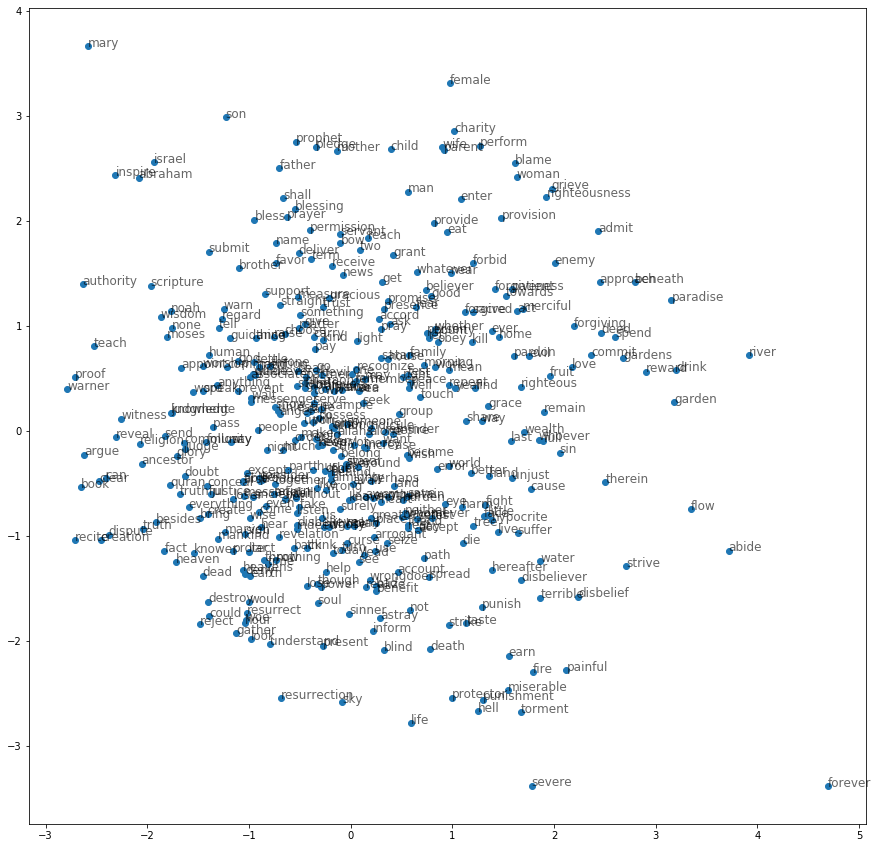

In [27]:
# create a scatter plot of the projection
f, a = plt.subplots(figsize=(15, 15))
a.scatter(result[:, 0], result[:, 1])
for i, word in enumerate(words):
    a.annotate(word, xy=(result[i, 0], result[i, 1]), alpha=0.6, fontsize=12)
# a.set_xlim([0, 3]); a.set_ylim([0, 3])
plt.show()

## Topics

### Parse by surah

In [28]:
if is_by_verse:
    df0['processed'] = processed
    processed_by_surah = df0.groupby('surah')['processed'].apply(sum).values.tolist()
else: 
    processed_by_surah = processed

### Making dictionary and corpus

In [29]:
# making dictionary and corpus
dictionary = corpora.Dictionary(processed_by_surah)
corpus = [dictionary.doc2bow(text) for text in processed_by_surah]
tfidf = models.TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]
# Save
#dictionary.save('/tmp/dict.dict')
#corpora.MmCorpus.serialize('/tmp/temp.mm', corpus)

### TFIDF

In [30]:
item_document_fre = dictionary.dfs
for k in dictionary.keys()[:4]:
    print(k, dictionary[k], item_document_fre[k])

0 allah 82
1 anger 4
2 bless 29
3 call 53


In [31]:
# Compare bow and tiidf
i = 0
print(processed_by_surah[i], '\n',
      [dictionary[k[0]] for k in corpus[i]], '\n',
      corpus[i], '\n', 
      corpus_tfidf[i])

['praise', 'allah', 'lord', 'world', 'gracious', 'merciful', 'master', 'day', 'judgment', 'worship', 'upon', 'call', 'help', 'guide', 'straight', 'path', 'path', 'bless', 'anger', 'misguide'] 
 ['allah', 'anger', 'bless', 'call', 'day', 'gracious', 'guide', 'help', 'judgment', 'lord', 'master', 'merciful', 'misguide', 'path', 'praise', 'straight', 'upon', 'world', 'worship'] 
 [(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 2), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1)] 
 [(0, 0.04845352024773868), (1, 0.492640036044582), (2, 0.2013121025870043), (3, 0.11263493315072866), (4, 0.043169325280030334), (5, 0.2982613828990869), (6, 0.10193487428861422), (7, 0.18683541317873928), (8, 0.24193818317734606), (9, 0.028368594012498187), (10, 0.2982613828990869), (11, 0.13669842963590823), (12, 0.43301195707001744), (13, 0.2936891720131065), (14, 0.14684458600655326), (15, 0.2231388877027208), (16, 0.07816374556897575), (17, 0.1695

### LDA

In [32]:
# LDA modeling
NUM_TOPICS = 15
NUM_WORDS = 10
NUM_PASSES = 2  # 10
NUM_WORKERS = 3  # better be n_cpu - 1

corpus_input = corpus_tfidf

# lda = models.LdaModel(corpus_input, id2word=dictionary, num_topics=NUM_TOPICS, passes=10)

lda = models.ldamulticore.LdaMulticore(corpus_input, 
                                       id2word=dictionary, 
                                       num_topics=NUM_TOPICS, 
                                       random_state=42, 
                                       passes=NUM_PASSES, 
                                       workers=NUM_WORKERS)


In [33]:
start_time = time.time()
print('Perplexity: ', lda.log_perplexity(corpus_input))
coherence_model_lda = models.CoherenceModel(
    model=lda, texts=processed, dictionary=dictionary, coherence='c_v')  #'umass' is faster
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)
print(time.time() - start_time, "seconds")



Perplexity:  -15.044749868056911

Coherence Score:  0.5826465075839383
50.59810447692871 seconds


### Hyperparameter optimization

In [34]:
# Use c_v - slow
# num_topics_list = range(12, 18)
# model_scores = []

# for NUM_TOPICS in num_topics_list:
#     start_time = time.clock()
#     lda = models.ldamulticore.LdaMulticore(corpus_input, id2word=dictionary, num_topics=NUM_TOPICS, random_state=42, passes=NUM_PASSES, workers=NUM_WORKERS)
#     coherence_model_lda = models.CoherenceModel(
#         model=lda, texts=processed, dictionary=dictionary, coherence='c_v')
#     coherence_lda = coherence_model_lda.get_coherence()
#     model_scores.append((NUM_TOPICS, lda, coherence_lda))
#     print("For {} topics: {} seconds".format(NUM_TOPICS, time.clock() - start_time))

# plt.plot([i[0] for i in model_scores], [i[2] for i in model_scores])
# max_model_score = max(model_scores, key=lambda x: x[2])
# lda_selected = max_model_score[1]
# print('Perplexity: ', lda_selected.log_perplexity(corpus_input))
    
    
    

    
# Use u_mass - faster
# num_topics_list = range(5, 21, 5)
# model_scores = []

# for NUM_TOPICS in num_topics_list:
#     start_time = time.clock()
#     lda = models.ldamulticore.LdaMulticore(corpus_input, id2word=dictionary, num_topics=NUM_TOPICS, random_state=42, passes=NUM_PASSES, workers=NUM_WORKERS)
#     coherence_model_lda = models.CoherenceModel(
#         model=lda, texts=processed, corpus=corpus_input, dictionary=dictionary, coherence='u_mass')  #'c_v' is too slow
#     coherence_lda = coherence_model_lda.get_coherence()
#     model_scores.append((NUM_TOPICS, lda, coherence_lda))
#     print("For {} topics: {} seconds".format(NUM_TOPICS, time.clock() - start_time))

# plt.plot([i[0] for i in model_scores], [i[2] for i in model_scores])
# max_model_score = max(model_scores, key=lambda x: x[2])
# lda_selected = max_model_score[1]
# print('Perplexity: ', lda_selected.log_perplexity(corpus_input))

In [35]:
# plt.plot(num_topics_list, coherence_scores)

#### get topics

In [36]:
lda_selected = lda  # if not using hyperparameter optimization
corpus_lda = lda_selected[corpus_input] 
topics = lda_selected.print_topics(num_topics=-1, num_words=NUM_WORDS)

### Results

#### Visualize

In [37]:
# # Visualize the topics
# pyLDAvis.enable_notebook()
# vis = pyLDAvis.gensim.prepare(lda, corpus_input, dictionary)
# vis

#### Check individual surah

In [38]:
# Get score for individual verse
i = 113
print(processed_by_surah[i])
sorted_rel = sorted(corpus_lda[i], key=lambda x: x[1], reverse=True)
print('Top 3 topics of this doc: \n', sorted_rel[:3])
print('First topic: \n', topics[sorted_rel[0][0]])
print('2nd topic: \n', topics[sorted_rel[1][0]])

['say', 'seek', 'refuge', 'lord', 'mankind', 'king', 'mankind', 'god', 'mankind', 'evil', 'sneaky', 'whisperer', 'whisper', 'heart', 'people', 'among', 'jinn', 'among', 'people']
Top 3 topics of this doc: 
 [(13, 0.76833546), (6, 0.016547676), (12, 0.016547604)]
First topic: 
 (13, '0.002*"mankind" + 0.001*"allah" + 0.001*"whisperer" + 0.001*"sneaky" + 0.001*"business" + 0.001*"allahhe" + 0.001*"spend" + 0.001*"entertainment" + 0.001*"whisper" + 0.001*"compassionate"')
2nd topic: 
 (6, '0.003*"allah" + 0.003*"say" + 0.002*"day" + 0.002*"people" + 0.002*"would" + 0.002*"use" + 0.002*"woe" + 0.002*"believe" + 0.002*"one" + 0.002*"sign"')


#### Dominant topics for each surah

In [39]:
ind_max_topic = [max(i, key=lambda x: x[1]) for i in corpus_lda]

In [40]:
df_top_topic = pd.DataFrame(ind_max_topic, columns=['top_topic_ind', 'top_topic_ind_prob'])

In [41]:
# df['top_topic_ind'] = [i[0] for i in ind_max_topic]
# df['top_topic_ind_prob'] = [i[1] for i in ind_max_topic]
# df.to_csv('climatetopics_topiced.csv', index=False)
# df = pd.read_csv('climatetopics_topiced.csv', converters={"processed": literal_eval})

# topic_ranked = df.groupby('top_topic_ind')['count'].sum().sort_values(ascending=False)

In [42]:
# for i in topic_ranked[:10].index.values:
#     print(topics[i])
#     display(df2[df2['top_topic_ind'] == i].sort_values('top_topic_ind_prob', ascending=False)[:3])
#     break

## WordCloud

### For all text

In [71]:
WC = WordCloud(max_font_size=60, width=400, height=300, background_color ='white', )

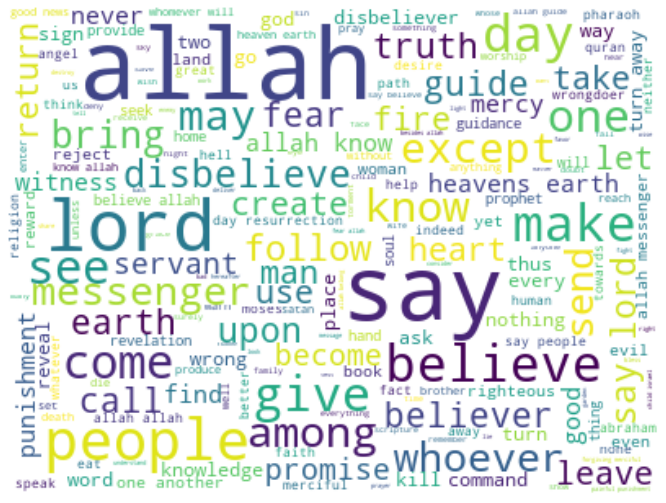

In [43]:
def word_cloud(corpus, wc=WC, method='generate', ind_list=None):
    def get_word_cloud(input_text):
        text = ' '.join(input_text)
        return getattr(wc, method)(text)
        
    if isinstance(corpus[0], list):  
        if ind_list is None:
            ind_list = range(len(corpus))
        n = len(ind_list)
        if n > 10:
            sys.exit(0)
        f, a = plt.subplots(nrows=n, figsize=(8, n * 6))
        for i, ind in enumerate(ind_list):
            wordcloud = get_word_cloud(corpus[ind])
            a[i].imshow(wordcloud, interpolation="bilinear")
        plt.axis("off")
        plt.show()
    else:
        f, ax = plt.subplots(figsize=(12, 9))
        wordcloud = get_word_cloud(corpus)
        plt.imshow(wordcloud, interpolation="bilinear")
        plt.axis("off")
        plt.show()
        
# Sample by 10 and plot word cloud
word_cloud([' '.join(doc) for ind, doc in enumerate(processed)]) # if ind % 5 == 0])


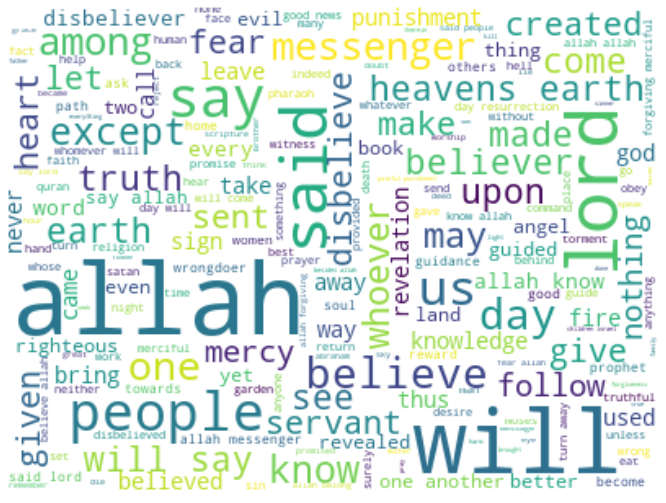

In [44]:
word_cloud(docs)

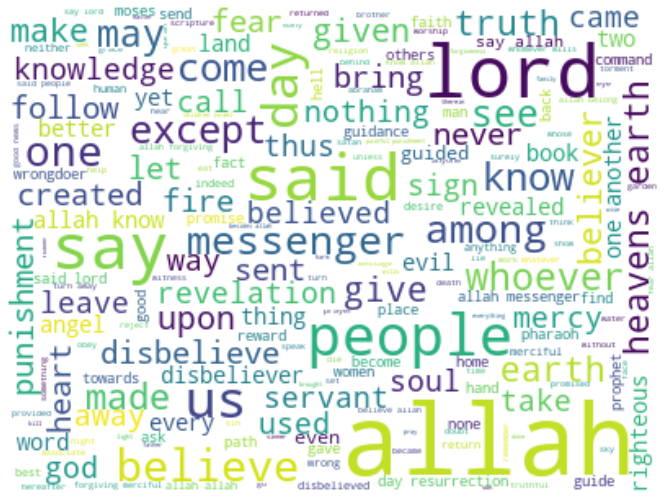

In [45]:
# after parsing
word_cloud([' '.join(ii) for ii in tokens])

### Word cloud by word freq (topic, tfidf, etc.)

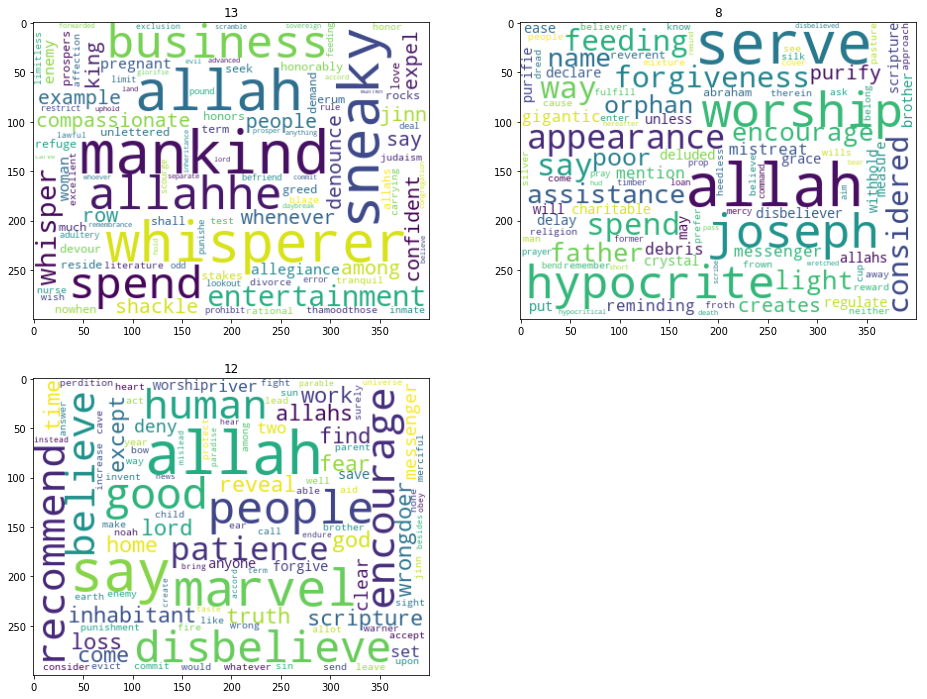

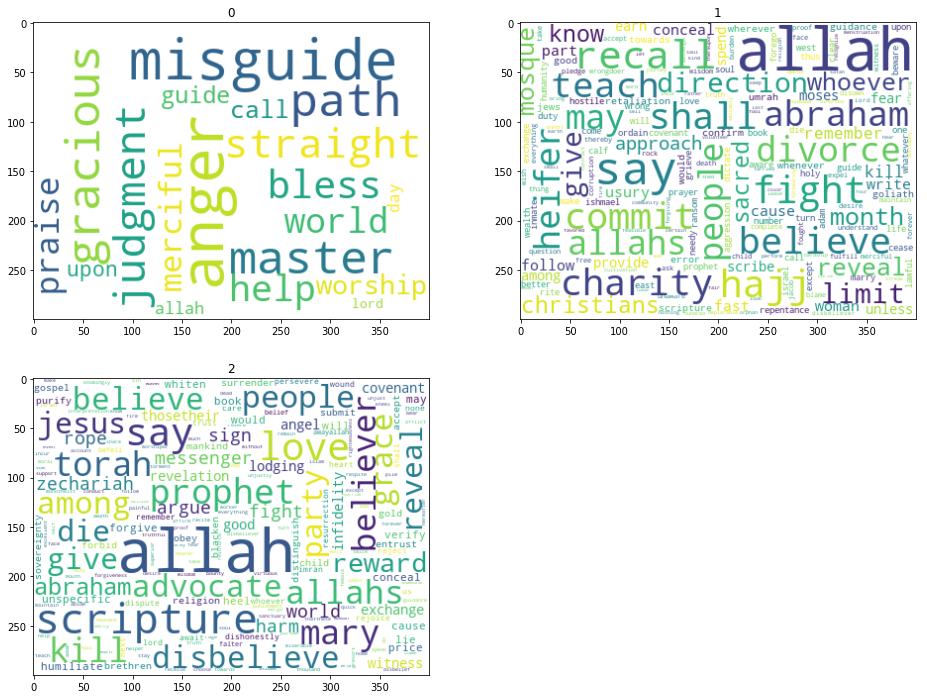

In [87]:
topics_for_wordcloud = lda_selected.show_topics(3, num_words=100, formatted=False)
# TFIDF: Get terms from the dictionary and pair with weights
corpus_ind_list = [0, 1, 2]
corpus_tfidf_by_word = [(ind, [(dictionary[pair[0]], pair[1]) for pair in corpus_tfidf[ind]]) for ind in corpus_ind_list]

def word_cloud_by_freq(a, wc=WC, method='generate_from_frequencies'):  # alias of 'fit_words'
    def get_word_cloud(x):
        return getattr(wc, method)(dict(x))
        
    n = len(a)
    n_rows = int(np.ceil(n / 2))
    if n > 20:
        sys.exit(0)
    f, ax = plt.subplots(nrows=n_rows, ncols=2, figsize=(16, n_rows * 6))
    for i, x in enumerate(a):
        word_freq = x[1]
        wordcloud = get_word_cloud(word_freq)
        axp = ax[i // 2][i % 2]
        axp.imshow(wordcloud, interpolation="bilinear")
        axp.set_title(x[0])
    plt.axis("off")
    plt.show()
    return wordcloud

word_cloud_by_freq(topics_for_wordcloud)
word_cloud_by_freq(corpus_tfidf_by_word)